# Executive Certificate Big Data - Centrale Supelec - Octobre 2018
# Détection d’intrusion réseau à l’aide de l’apprentissage automatique
### Notebook : sp4_anomaly-detection-model
### Auteur : Ahmed Mekaouar

# Anomaly detection model

In [2]:
import os
import pandas as pd
import numpy as np

### Load baseline, attack and novelty data 

In [3]:
# Get the data before any feature selection is made, so avoiding that RF feature selection introduce a biais in movelty
# detection model
intermediary_data_path = os.path.join(os.path.pardir,'data','intermediary')
baseline_file_path = os.path.join(intermediary_data_path, 'train_baseline.csv')
attacks_file_path = os.path.join(intermediary_data_path, 'train_attacks.csv')
novelty_file_path = os.path.join(intermediary_data_path, 'novelty.csv')

In [4]:
df = pd.read_csv(baseline_file_path).drop(columns='Flow ID')
df2 = pd.read_csv(attacks_file_path).drop(columns='Flow ID')
df3 = pd.read_csv(novelty_file_path).drop(columns='Flow ID')

In [5]:
X = df.drop(columns=['Label'],axis=1)

In [6]:
X2 = df2.drop(columns=['Label'],axis=1)

In [7]:
X2_DoSHulk = df2[df2.Label=='DoS Hulk'].drop(columns=['Label'],axis=1)
X2_PortScan = df2[df2.Label=='PortScan'].drop(columns=['Label'],axis=1)
X2_DDoS = df2[df2.Label=='DDoS'].drop(columns=['Label'],axis=1)
X2_DoSGoldenEye = df2[df2.Label=='DoS GoldenEye'].drop(columns=['Label'],axis=1)
X2_FTPPatator = df2[df2.Label=='FTP-Patator'].drop(columns=['Label'],axis=1)
X2_SSHPatator = df2[df2.Label=='SSH-Patator'].drop(columns=['Label'],axis=1)
X2_DoSslowloris = df2[df2.Label=='DoS slowloris'].drop(columns=['Label'],axis=1)
X2_Bot = df2[df2.Label=='Bot'].drop(columns=['Label'],axis=1)
X2_AttackBruteForce = df2[df2.Label=='Web Attack Brute Force'].drop(columns=['Label'],axis=1)
X3_DoSSlowhttptest = df3.drop(columns=['Label'],axis=1)

## One Class SVM for anomaly detection

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split( X, test_size=0.2, random_state=24)
X_train = X_train.sample(frac=0.1 ,random_state=24)
X_test = X_test.sample(frac=0.1 ,random_state=24)
# Here we undersample majority classes for train/test to speed up the training/prediction

### Features scaling - Train and test data need to be trained separately with the same scaler

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

In [9]:
from sklearn.externals import joblib
ocsvm_scaler_file = os.path.join(os.path.pardir,'models','ocsvm_scaler_model.pkl')
joblib.dump(scaler, ocsvm_scaler_file)

['..\\models\\ocsvm_scaler_0207.pkl']

In [10]:
from sklearn import svm

clf_ocsvm = svm.OneClassSVM(nu=0.1,
                      kernel="rbf",
                      gamma=0.2,
                      random_state=24,
                      cache_size=200)

In [11]:
%%time
clf_ocsvm.fit(X_train_scaled)
# nu = 0.06, g=0.04  -> 11min 13s
# nu = 0.07, g=0.08 -> 12min 54s
# nu = 0.1, g=0.2 ->  17min 40s
# nu = 0.2, g=0.4  -> 33min 40s
# nu = 0.4, g=0.6  -> 1h 1min 2s
# nu = 0.6, g=1  -> 1h 8min 46s 

Wall time: 17min 40s


OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.2, kernel='rbf',
      max_iter=-1, nu=0.1, random_state=24, shrinking=True, tol=0.001,
      verbose=False)

In [16]:
# Save one class svm 
from sklearn.externals import joblib
OCSVM_model_file = os.path.join(os.path.pardir,'models','ocsvm_nu06_g1_model_2008.pkl')
joblib.dump(clf_ocsvm, OCSVM_model_file)

['..\\models\\ocsvm_nu06_g1_model_2008.pkl']

In [58]:
# Load one class svm 
from sklearn.externals import joblib
OCSVM_model_file = os.path.join(os.path.pardir,'models','06-03-S02-OCSVM_G03_nu01_model.pkl')
clf = joblib.load(OCSVM_model_file)

In [17]:
%%time
y_pred_test = clf_ocsvm.predict(X_test_scaled)

Wall time: 6min 3s


In [18]:
pd.Series(y_pred_test).value_counts(normalize=True)
# nu = 0.1, g=0.2  ->  -1    0.101109 
# nu = 0.01, g=0.001  -> -1    0.010856 
# nu = 0.02, g=0.01  -> -1    0.02034
# nu = 0.04, g=0.02  -> -1    0.039616
# nu = 0.06, g=0.04  -> -1    0.0605
# nu = 0.07, g=0.08  -> -1    0.070079
# nu = 0.2, g=0.4  -> -1    0.20527
# nu = 0.4, g=0.6  -> -1    0.393557
# nu = 0.6, g=1  -> -1    0.591495

-1    0.591495
 1    0.408505
dtype: float64

In [19]:
# I evaluate the detector on attacks 
X2_scaled = scaler.transform(X2)

In [20]:
%%time
y2_pred = clf_ocsvm.predict(X2_scaled)

Wall time: 1h 5min 48s


In [21]:
pd.Series(y2_pred).value_counts(normalize=True)
# nu = 0.01, g=0.001   -> -1    0.022889
# nu = 0.02, g=0.01  -> -1    0.323586
# nu = 0.04, g=0.02  ->  -1    0.350494
# nu = 0.06, g=0.04  -> -1    0.363936
# nu = 0.07, g=0.08   -> -1    0.407584
# nu = 0.1, g=0.2  -> -1    0.583815 
# nu = 0.2, g=0.4  -> -1    0.635126
# nu = 0.4, g=0.6  -> -1    0.724523
# nu = 0.6, g=1  -> -1    0.873515

-1    0.873515
 1    0.126485
dtype: float64

In [26]:
%%time
X2_DDoS_scaled = scaler.transform(X2_DDoS)
y2_DDoS_pred = clf_ocsvm.predict(X2_DDoS_scaled)

Wall time: 5min 32s


In [91]:
pd.Series(y2_DDoS_pred).value_counts(normalize=True)
# nu = 0.01, g=0.001  -> -1    0.05698
# nu = 0.02, g=0.01  -> -1    0.255442
# nu = 0.04, g=0.02  -> -1    0.303066
# nu = 0.06, g=0.04  -> -1    0.320686
# nu = 0.07, g=0.08   -> -1    0.322677
# nu = 0.1, g=0.2  ->  -1    0.335443 
# nu = 0.2, g=0.4  -> -1    0.411625
# nu = 0.4, g=0.6  -> -1    0.699553

-1    0.699553
 1    0.300447
dtype: float64

In [92]:
%%time
X2_SSHPatator_scaled = scaler.transform(X2_SSHPatator)
y2_SSHPatator_pred = clf_ocsvm.predict(X2_SSHPatator_scaled)

Wall time: 29 s


In [93]:
pd.Series(y2_SSHPatator_pred).value_counts(normalize=True)
# nu = 0.01, g=0.001  -> -1    0.000188
# nu = 0.02, g=0.01  ->  -1    0.000563
# nu = 0.04, g=0.02  -> -1    0.000563
# nu = 0.06, g=0.04  -> -1    0.000563
# nu = 0.07, g=0.08   -> -1    0.001125
# nu = 0.1, g=0.2  ->  -1    0.001125
# nu = 0.2, g=0.4  ->  -1    0.226974
# nu = 0.4, g=0.6  -> -1    0.50891

-1    0.50891
 1    0.49109
dtype: float64

In [94]:
%%time
X2_FTPPatator_scaled = scaler.transform(X2_FTPPatator)
y2_FTPPatator_pred = clf_ocsvm.predict(X2_FTPPatator_scaled)

Wall time: 39 s


In [95]:
pd.Series(y2_FTPPatator_pred).value_counts(normalize=True)

# nu = 0.01, g=0.001  ->  -1    0.000698
# nu = 0.02, g=0.01  -> -1    0.000977
# nu = 0.04, g=0.02  -> -1    0.013817
# nu = 0.06, g=0.04  -> -1    0.019819
# nu = 0.07, g=0.08   ->  -1    0.006978 ( value error - to be checked!)
# nu = 0.1, g=0.2  ->  -1    0.132589
# nu = 0.2 , g=0.4 -> -1    0.237264
# nu = 0.4, g=0.6  -> -1    0.997627

-1    0.997627
 1    0.002373
dtype: float64

In [96]:
%%time
X2_DoSGoldenEye_scaled = scaler.transform(X2_DoSGoldenEye)
y2_DoSGoldenEye_pred = clf_ocsvm.predict(X2_DoSGoldenEye_scaled)

Wall time: 48 s


In [97]:
pd.Series(y2_DoSGoldenEye_pred).value_counts(normalize=True)
# nu = 0.01, g=0.001  ->  -1    0.089624
# nu = 0.02, g=0.01  -> -1    0.336091
# nu = 0.04, g=0.02  -> -1    0.528324
# nu = 0.06, g=0.04  -> -1    0.677812
# nu = 0.07, g=0.08   ->  -1    0.779272
# nu = 0.1, g=0.2  ->  -1    0.919798
# nu = 0.2, g=0.4  -> -1    0.960358
# nu = 0.4, g=0.6  -> -1    0.999311 

-1    0.999311
 1    0.000689
dtype: float64

In [98]:
%%time
X2_DoSslowloris_scaled = scaler.transform(X2_DoSslowloris)
y2_DoSslowloris_pred = clf_ocsvm.predict(X2_DoSslowloris_scaled)

Wall time: 27.2 s


In [99]:
pd.Series(y2_DoSslowloris_pred).value_counts(normalize=True)
# nu = 0.01 g=0.001  ->  -1    0.089959
# nu = 0.02, g=0.01  -> -1    0.545697
# nu = 0.04, g=0.02  -> -1    0.572541
# nu = 0.06, g=0.04  -> -1    0.577664
# nu = 0.07, g=0.08   -> -1    0.867213
# nu = 0.1, g=0.2  ->  -1    0.885041
# nu = 0.2, g=0.4  -> -1    0.971311
# nu = 0.4, g=0.6  -> -1    0.998566

-1    0.998566
 1    0.001434
dtype: float64

In [28]:
%%time
X3_DoSSlowhttptest_scaled = scaler.transform(X3_DoSSlowhttptest)
y3_DoSSlowhttptest_pred = clf_ocsvm.predict(X3_DoSSlowhttptest_scaled)

Wall time: 47.9 s


In [29]:
pd.Series(y3_DoSSlowhttptest_pred).value_counts(normalize=True)
# nu = 0.01, g=0.001  -> -1    0.235688
# nu = 0.02, g=0.01  -> -1    0.684242
# nu = 0.04, g=0.02  -> -1    0.907338
# nu = 0.06, g=0.04  -> -1    0.958292
# nu = 0.07, g=0.08   ->  -1    0.963604
# nu = 0.1, g=0.2  -> -1    0.986229
# nu = 0.2, g=0.4  -> -1    0.995672
# nu = 0.4, g=0.6  -> -1    0.999213
# nu = 0.6, g=1  -> -1    0.999607

-1    0.999607
 1    0.000393
dtype: float64

In [101]:
%%time
X2_AttackBruteForce_scaled = scaler.transform(X2_AttackBruteForce)
y2_AttackBruteForce_pred = clf_ocsvm.predict(X2_AttackBruteForce_scaled)

Wall time: 6.8 s


In [102]:
pd.Series(y2_AttackBruteForce_pred).value_counts(normalize=True)
# nu = 0.01, g=0.001  -> -1   0
# nu = 0.02, g=0.01  -> -1    0.049442
# nu = 0.04, g=0.02  -> -1    0.050239
# nu = 0.06, g=0.04  -> -1    0.050239
# nu = 0.07, g=0.08  -> -1    0.051037
# nu = 0.1, g=0.2  -> -1    0.052632
# nu = 0.2, g=0.4  -> -1    0.055821
# nu = 0.4, g=0.6  -> -1    0.497608

 1    0.502392
-1    0.497608
dtype: float64

In [103]:
%%time
X2_Bot_scaled = scaler.transform(X2_Bot)
y2_Bot_pred = clf_ocsvm.predict(X2_Bot_scaled)

Wall time: 9.48 s


In [104]:
pd.Series(y2_Bot_pred).value_counts(normalize=True)
# nu = 0.01, g=0.001  -> -1    0.025656
# nu = 0.02, g=0.01  -> -1    0.023945
# nu = 0.04, g=0.02  -> -1    0.027936
# nu = 0.06, g=0.04  -> -1    0.029076
# nu = 0.07, g=0.08  -> -1    0.031927
# nu = 0.1, g=0.2  -> -1    0.0439
# nu = 0.2, g=0.4  -> -1    0.09236
# nu = 0.4, g=0.6  -> -1    0.400228

 1    0.599772
-1    0.400228
dtype: float64

In [105]:
%%time
X2_PortScan_scaled = scaler.transform(X2_PortScan)
y2_PortScan_pred = clf_ocsvm.predict(X2_PortScan_scaled)

Wall time: 13min 10s


In [106]:
pd.Series(y2_PortScan_pred).value_counts(normalize=True)
# nu = 0.01, g=0.001  ->  -1    0.003035
# nu = 0.02, g=0.01  -> -1    0.004811
# nu = 0.04, g=0.02  -> -1    0.008896
# nu = 0.06, g=0.04  -> -1    0.016987
# nu = 0.07, g=0.08  -> -1   0.06343
# nu = 0.1, g=0.2  ->  -1    0.518619 (retrieved from backup file)
# nu = 0.2, g=0.4  -> -1    0.550635
# nu = 0.4, g=0.6  -> -1    0.574469

-1    0.574469
 1    0.425531
dtype: float64

In [75]:
%%time
X2_DoSHulk_scaled = scaler.transform(X2_DoSHulk)
y2_DoSHulk_pred = clf_ocsvm.predict(X2_DoSHulk_scaled)

Wall time: 9min 4s


In [76]:
pd.Series(y2_DoSHulk_pred).value_counts(normalize=True)
# nu = 0.01, g=0.001  -> -1    0.027937
# nu = 0.02, g=0.01  ->  -1    0.591743
# nu = 0.04, g=0.02  ->  -1    0.625854
# nu = 0.06, g=0.04  -> -1    0.637401
# nu = 0.07, g=0.08  -> -1    0.68213
# nu = 0.1, g=0.2  -> -1    0.698164
# nu = 0.2, g=0.4  -> -1    0.753016
# nu = 0.4, g=0.6  ->

-1    0.753016
 1    0.246984
dtype: float64

## ROC curve

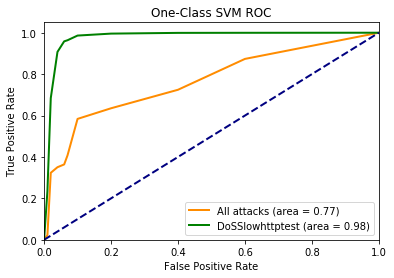

In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# This is an adaptation from  http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

fpr = [0,0.01,0.02,0.04,0.06,0.07,0.1,0.2,0.4,0.6,1]
tpr_attacks =[0,0.022889, 0.323586,0.350494,0.363936,0.407584,0.583815,0.635126,0.724523,0.873515,1]
tpr_DoSSlowhttptest =[0,0.235688, 0.684242,0.907338,0.958292,0.963604,0.986229,0.995672,0.999213,0.999607,1]
roc_auc_all = auc(fpr,tpr_attacks)
roc_auc_DoSSlowhttptest = auc(fpr,tpr_DoSSlowhttptest)

plt.figure()
lw = 2
plt.plot(fpr, tpr_attacks, color='darkorange',
         lw=lw, label='All attacks (area = %0.2f)' % roc_auc_all)
plt.plot(fpr, tpr_DoSSlowhttptest, color='green',
         lw=lw, label='DoSSlowhttptest (area = %0.2f)' % roc_auc_DoSSlowhttptest)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-Class SVM ROC')
plt.legend(loc="lower right")
plt.show()

# IsolationForest for Outlier detection

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split( X, test_size=0.5, random_state=24)
X2_train, X2_test = train_test_split( X2, test_size=0.99, random_state=24)
X_train = X_train.sample(frac=0.1 ,random_state=24)
X_train = pd.concat([X_train,X2_train])

In [18]:
X_train.shape

(121925, 68)

In [19]:
X2_train.shape

(4478, 68)

In [20]:
from sklearn.ensemble import IsolationForest
clf_IF = IsolationForest(n_estimators=200,
                         contamination=0.0354,
                         random_state=0,
                         n_jobs=1)

In [21]:
%%time
clf_IF.fit(X_train)

Wall time: 27.7 s


IsolationForest(bootstrap=False, contamination=0.0354, max_features=1.0,
        max_samples='auto', n_estimators=200, n_jobs=1, random_state=0,
        verbose=0)

In [24]:
# Save IsolationForest model
from sklearn.externals import joblib
IF_model_file = os.path.join(os.path.pardir,'models','2018-06-06-IF_model.pkl')
joblib.dump(clf_IF, IF_model_file)

['..\\models\\2018-06-06-IF_model.pkl']

In [22]:
%%time
y_pred_train = clf_IF.predict(X_train)

Wall time: 16.3 s


In [23]:
pd.Series(y_pred_train).value_counts(normalize=True)

 1    0.964593
-1    0.035407
dtype: float64

In [24]:
%%time
y_pred_test = clf_IF.predict(X_test.sample(frac=0.3 ,random_state=24))
# Sampling to avoid memory error

Wall time: 58 s


In [25]:
pd.Series(y_pred_test).value_counts(normalize=True)

 1    0.972135
-1    0.027865
dtype: float64

In [26]:
X2_test.shape

(443376, 68)

In [27]:
%%time
y2_pred = clf_IF.predict(X2_test.sample(frac=0.5 ,random_state=24))
# Sampling to avoid memmory error

Wall time: 29.9 s


In [28]:
pd.Series(y2_pred).value_counts(normalize=True)

 1    0.766347
-1    0.233653
dtype: float64

In [36]:
%%time
y3_DoSSlowhttptest_pred = clf_IF.predict(X3_DoSSlowhttptest)

Wall time: 608 ms


In [37]:
pd.Series(y3_DoSSlowhttptest_pred).value_counts(normalize=True)

 1    0.751721
-1    0.248279
dtype: float64